## Final Project: Classifying Fores Fires in Arizona

In [1]:
%matplotlib inline

import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import scipy
import statsmodels.api as sm
import random

from skimage.io import imread as imread
from skimage.util import montage
import cv2
from skimage.color import rgb2gray
from PIL import Image, ImageFilter, ImageOps
import PIL
from PIL import Image

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

from sklearn import svm
# Importing keras library for creating Convolution Neural Network(CNN)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Activation, Dense,Dropout, Flatten, BatchNormalization,Reshape, ZeroPadding2D, Cropping2D
from tensorflow.keras.layers import MaxPooling2D, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.preprocessing.image import  array_to_img, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU
from keras.wrappers.scikit_learn import KerasClassifier
import math


# libraries for file operations
import os
import pathlib
import warnings
warnings.filterwarnings('ignore')

In [2]:
input_path ='C:\\Users\\User\\MUSA\\Training\\Training\\Fire'
image_df_train_f = pd.DataFrame({'path': list(Path(input_path).glob('**/*.jp*g'))})
image_df_train_f['fire'] = image_df_train_f['path'].map(lambda x: x.parent.stem)
image_df_train_f['path'] = image_df_train_f['path'].map(lambda x: str(x)) # convert the path back to a string
image_df_train_f['label'] = 1

input_path ='C:\\Users\\User\\MUSA\\Training\\Training\\No_Fire'
image_df_train_nf = pd.DataFrame({'path': list(Path(input_path).glob('**/*.jp*g'))})
image_df_train_nf['fire'] = image_df_train_nf['path'].map(lambda x: x.parent.stem)
image_df_train_nf['path'] = image_df_train_nf['path'].map(lambda x: str(x)) 
image_df_train_nf['label'] = 0

input_path ='C:\\Users\\User\\MUSA\\Test\\Fire'
image_df_test_f = pd.DataFrame({'path': list(Path(input_path).glob('**/*.jp*g'))})
image_df_test_f['fire'] = image_df_test_f['path'].map(lambda x: x.parent.stem)
image_df_test_f['path'] = image_df_test_f['path'].map(lambda x: str(x)) 
image_df_test_f['label'] = 1

input_path ='C:\\Users\\User\\MUSA\\Test\\No_Fire'
image_df_test_nf = pd.DataFrame({'path': list(Path(input_path).glob('**/*.jp*g'))})
image_df_test_nf['fire'] = image_df_test_nf['path'].map(lambda x: x.parent.stem)
image_df_test_nf['path'] = image_df_test_nf['path'].map(lambda x: str(x)) 
image_df_test_nf['label'] = 0

#### IMAGE PREPROCESSING

In [3]:
image_df_train = pd.concat([image_df_train_f, image_df_train_nf], ignore_index=True)
print("Number of photos in training set:", image_df_train.shape[0])
image_df_test = pd.concat([image_df_test_f, image_df_test_nf], ignore_index=True)
print("Number of photos in test set:", image_df_test.shape[0])
print("")
img = cv2.imread(image_df_train['path'][0])
print(f"dimensions of each image: {np.shape(img)}")
print("the size of each image is 254 x 254 and has 3 channels")

Number of photos in training set: 39375
Number of photos in test set: 8617

dimensions of each image: (254, 254, 3)
the size of each image is 254 x 254 and has 3 channels


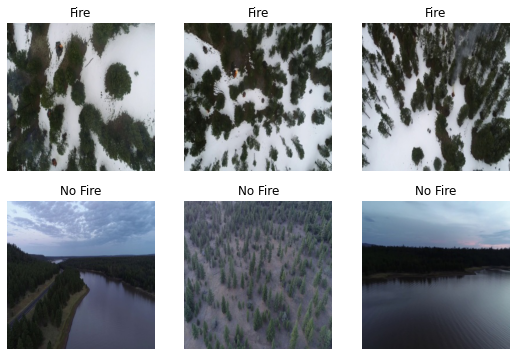

In [4]:
#visualize some of the images at random
random.seed(17)
fire_photos = np.random.choice(image_df_train_f['path'], 3, replace = False)
non_photos = np.random.choice(image_df_train_nf['path'], 3, replace = False)

fig = plt.figure(figsize = (9,6))
for i in range(6):
    if i < 3:
        image = fire_photos[i]
        label = 'Fire'
    else:
        image = non_photos[i-3]
        label = 'No Fire'
    ax = fig.add_subplot(2, 3, i+1)
    
    img = PIL.Image.open(image)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.show()

In [4]:
#take 15% of the sample
random.seed(17)
f = random.sample(range(0, 39375), 5900)
data_sample_trv = image_df_train.iloc[f,:]
e = (data_sample_trv['label'] == 1).sum()
print("Number of images with fire in training sample:", e)

g = random.sample(range(0, 8617), 1300)
data_sample_test = image_df_test.iloc[g,:]
k = (data_sample_test['label'] == 1).sum()

Number of images with fire in training sample: 3719


In [5]:
#read in training data sample and turn into x and y matrix
print("training/val sample set:")

def read_to_matrix(df):
  x = []
  for d in df['path']:
    d = cv2.imread(d)
    x.append(d)
  x = (np.asarray(x)).astype(np.uint8)
  x_train_samp = (x.flatten().reshape(5900,193548))
  print('matrix x shape =', x_train_samp.shape)
  y_train_samp = np.array(df['label'])
  print('matrix y shape =', y_train_samp.shape)
  return x_train_samp, y_train_samp

a = read_to_matrix(data_sample_trv)

training/val sample set:
matrix x shape = (5900, 193548)
matrix y shape = (5900,)


In [6]:
np.save('x_train_sample.npy', a[0])
np.save('y_train_sample.npy', a[1])

In [7]:
#reading in testing sample data
print("test sample set:")

def read_to_matrix(df):
  x = []
  for d in df['path']:
    d = cv2.imread(d)
    x.append(d)
  x = (np.asarray(x)).astype(np.uint8)
  x_test_samp = (x.flatten().reshape(1300,193548))
  print ('matrix x shape =', x_test_samp.shape)
  y_test_samp = np.array(df['label'])
  print ('matrix y shape =', y_test_samp.shape)
  return x_test_samp, y_test_samp

a = read_to_matrix(data_sample_test)

test sample set:
matrix x shape = (1300, 193548)
matrix y shape = (1300,)


In [8]:
np.save('x_test_sample.npy', a[0])
np.save('y_test_sample.npy', a[1])

#### Building the Autoencoder

In [2]:
x_train_sample = np.load('x_train_sample.npy')

In [2]:
x_test_sample = np.load('x_test_sample.npy')

In [3]:
autoenc3 = tf.keras.models.Sequential(name = 'Auto-Encoder_3')
#encode
autoenc3.add(ZeroPadding2D((1,1),input_shape = (254,254,3) ))
autoenc3.add(Conv2D(8, 3, padding = 'same' ))
autoenc3.add(LeakyReLU())
autoenc3.add(MaxPooling2D(pool_size = (2,2), strides = 2))  
autoenc3.add(Conv2D(16, 3, padding = 'same'))
autoenc3.add(LeakyReLU())
autoenc3.add(MaxPooling2D(pool_size = (2,2), strides = 2))
autoenc3.add(Conv2D(32, 3, padding = 'same'))
autoenc3.add(LeakyReLU())
autoenc3.add(MaxPooling2D(pool_size = (2,2), strides = 2))
#decode
autoenc3.add(UpSampling2D(2))
autoenc3.add(Conv2D(16, 1, padding = 'same'))
autoenc3.add(LeakyReLU())
autoenc3.add(UpSampling2D(2))
autoenc3.add(Conv2D(8, 1, padding = 'same'))
autoenc3.add(LeakyReLU())
autoenc3.add(UpSampling2D(2))
autoenc3.add(Conv2D(3, 1, activation = 'sigmoid', padding = 'same'))
autoenc3.add(Cropping2D(cropping=((1, 1), (1, 1))))
autoenc3.compile(loss = 'mse', optimizer = Adam(lr = 0.0001))

In [4]:
autoenc3.summary()

Model: "Auto-Encoder_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 8)       224       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      1168      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)     

In [4]:
best_model = ModelCheckpoint('autoenc3.h5', monitor='val_loss', verbose=1, save_best_only=True)

In [5]:
hist = autoenc3.fit(np.float16(x_train_sample/255.).reshape(5900, 254, 254,3), np.float16(x_train_sample/255.).reshape(5900, 254, 254,3), batch_size = 32, epochs = 16, 
            validation_split = 0.2, shuffle=True, verbose=1, callbacks=[best_model])

Epoch 1/16
148/148 [==============================] - 239s 2s/step - loss: 0.0657 - val_loss: 0.0436

Epoch 00001: val_loss improved from inf to 0.04360, saving model to autoenc3.h5
Epoch 2/16
148/148 [==============================] - 225s 2s/step - loss: 0.0348 - val_loss: 0.0178

Epoch 00002: val_loss improved from 0.04360 to 0.01777, saving model to autoenc3.h5
Epoch 3/16
148/148 [==============================] - 220s 1s/step - loss: 0.0164 - val_loss: 0.0139

Epoch 00003: val_loss improved from 0.01777 to 0.01390, saving model to autoenc3.h5
Epoch 4/16
148/148 [==============================] - 219s 1s/step - loss: 0.0135 - val_loss: 0.0127

Epoch 00004: val_loss improved from 0.01390 to 0.01273, saving model to autoenc3.h5
Epoch 5/16
148/148 [==============================] - 217s 1s/step - loss: 0.0125 - val_loss: 0.0121

Epoch 00005: val_loss improved from 0.01273 to 0.01210, saving model to autoenc3.h5
Epoch 6/16
148/148 [==============================] - 215s 1s/step - loss:

In [ ]:
#autoenc3.save_weights('autoenc3.h5')

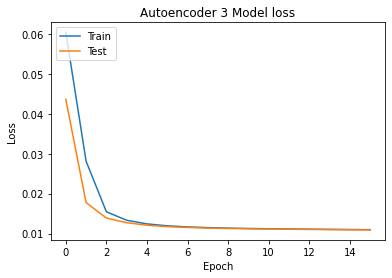

In [6]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Autoencoder 3 Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [4]:
autoenc3.load_weights('autoenc3.h5') 

In [5]:
def use_encoder(array, len):
  decoded_imgs_ = autoenc3.predict(array.reshape(len,254,254,3))
  return decoded_imgs_

decoded_imgs = use_encoder(np.float16(x_train_sample/255.), 5900)

Original vs Reconstructed Images for Training Set


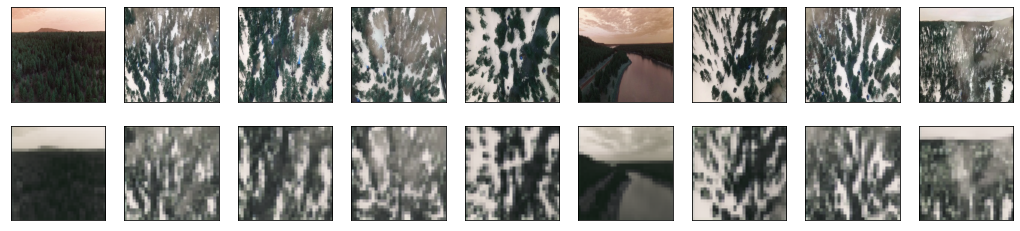

In [8]:
print("Original vs Reconstructed Images for Training Set")
n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train_sample[i].reshape(254,254,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(254,254,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [9]:
np.save('x_train_sample_enc.npy', decoded_imgs)

In [3]:
#encoder
encoder_input = keras.Input(shape=(254,254,3), name="original_img")
encd = ZeroPadding2D((1,1),input_shape = (254,254,3) )(encoder_input)
encd = Conv2D(8, 3, padding = 'same' )(encd)
encd = LeakyReLU()(encd)
encd = MaxPooling2D(pool_size = (2,2), strides = 2)(encd)
encd = Conv2D(16, 3, padding = 'same')(encd)
encd = LeakyReLU()(encd)
encd = MaxPooling2D(pool_size = (2,2), strides = 2)(encd)
encd = Conv2D(32, 3, padding = 'same')(encd)
encd = LeakyReLU()(encd)
encoder_output = MaxPooling2D(pool_size = (2,2), strides = 2)(encd)

In [4]:
#decoder
decd = UpSampling2D(2)(encoder_output)
decd = Conv2D(16, 1, padding = 'same')(decd)
decd = LeakyReLU()(decd)
decd = UpSampling2D(2)(decd)
decd = Conv2D(8, 1, padding = 'same')(decd)
decd = LeakyReLU()(decd)
decd = (UpSampling2D(2))(decd)
decd = Conv2D(3, 1, activation = 'sigmoid', padding = 'same')(decd)
out_layer = Cropping2D(cropping=((1, 1), (1, 1)))(decd)
model = keras.Model(encoder_input, out_layer, name="model")
model.compile(loss = 'mse', optimizer = Adam(lr = 0.0001))

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_img (InputLayer)    [(None, 254, 254, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 8)       224       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      1168      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 16)      0     

In [6]:
model.fit(np.float16(x_train_sample/255.).reshape(5900, 254, 254,3), np.float16(x_train_sample/255.).reshape(5900, 254, 254,3), batch_size = 32, epochs = 16, 
            validation_split = 0.2, shuffle=True, verbose=1)

Epoch 1/16
148/148 [==============================] - 245s 2s/step - loss: 0.0694 - val_loss: 0.0535
Epoch 2/16
148/148 [==============================] - 234s 2s/step - loss: 0.0461 - val_loss: 0.0217
Epoch 3/16
148/148 [==============================] - 231s 2s/step - loss: 0.0195 - val_loss: 0.0154
Epoch 4/16
148/148 [==============================] - 227s 2s/step - loss: 0.0150 - val_loss: 0.0135
Epoch 5/16
148/148 [==============================] - 231s 2s/step - loss: 0.0133 - val_loss: 0.0124
Epoch 6/16
148/148 [==============================] - 257s 2s/step - loss: 0.0122 - val_loss: 0.0119
Epoch 7/16
148/148 [==============================] - 244s 2s/step - loss: 0.0118 - val_loss: 0.0117
Epoch 8/16
148/148 [==============================] - 238s 2s/step - loss: 0.0117 - val_loss: 0.0115
Epoch 9/16
148/148 [==============================] - 234s 2s/step - loss: 0.0114 - val_loss: 0.0114
Epoch 10/16
148/148 [==============================] - 234s 2s/step - loss: 0.0113 - val_lo

In [7]:
encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.save('encoder.h5')

In [3]:
from tensorflow.keras.models import load_model
encoder = load_model('encoder.h5')

In [4]:
encoder.compile(loss = 'mse', optimizer = Adam(lr = 0.0001))

In [5]:
def use_encoder(array, len):
  decoded_imgs_ = encoder.predict(array.reshape(len,254,254,3))
  return decoded_imgs_

x_train_sample_encoded = use_encoder(np.float16(x_train_sample/255.), 5900)

In [6]:
np.save('x_train_sample_encodedr.npy', x_train_sample_encoded)

### Nested Cross Validation For SVM

In [2]:
x_train_sample_enc = np.load('x_train_sample_encodedr.npy')
y_train_sample = np.load('y_train_sample.npy')

In [9]:
x_train_sample_encr = x_train_sample_enc.reshape(5900,32*32*32)

In [4]:
x_train_sample_enc[2].shape

(32, 32, 32)

In [10]:
# Doing Nested CV for SVM
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf2 = SVC(random_state=1, probability=False)

# Making the pipelines

pipe2 = Pipeline([('std', StandardScaler()),
                  ('clf2', clf2)])

# Setting up the parameter grids

param_grid2 = [{'clf2__kernel': ['rbf'],
                'clf2__C': np.power(10., np.arange(-3, 3)),
                'clf2__gamma': np.power(10., np.arange(-5, -1))},
               {'clf2__kernel': ['linear'],
                'clf2__C': np.power(10., np.arange(-3, 3))}]


In [11]:
# Setting up Gridsearchcv objects
gridcvs = {}
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

gcv = GridSearchCV(estimator=pipe2,
                       param_grid=param_grid2,
                       scoring='average_precision',
                       n_jobs=-1,
                       cv=inner_cv,
                       verbose=0, 
                       refit=True)
gridcvs['SVM'] = gcv

In [12]:
for name, gs_est in (gridcvs.items()):

    print('Algorithm:', name)
    print('    Inner loop:')
    
    outer_scores = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    
    for a, b in outer_cv.split(x_train_sample_encr, y_train_sample):
        
        gridcvs[name].fit(x_train_sample_encr[a], y_train_sample[a]) # run inner loop hyperparam tuning
        print(f"\n        Best PR AUC (avg. of inner test folds) {(gridcvs[name].best_score_ ):.4f}")
        print("        Best parameters: ", (gridcvs[name].best_params_))
        
        # perf on test fold (b)
        outer_scores.append(gridcvs[name].best_estimator_.score(x_train_sample_encr[b], y_train_sample[b]))
        print(f"        PR AUC (on outer test fold) {(outer_scores[-1]):.4f}")
    
    print('\n    Outer Loop:')
    print(f"        PR AUC ({(np.mean(outer_scores)):.4f} +/- {(np.std(outer_scores)):.4f}")

Algorithm: SVM
    Inner loop:

        Best PR AUC (avg. of inner test folds) 0.9999
        Best parameters:  {'clf2__C': 10.0, 'clf2__gamma': 0.0001, 'clf2__kernel': 'rbf'}
        PR AUC (on outer test fold) 0.9847

        Best PR AUC (avg. of inner test folds) 0.9999
        Best parameters:  {'clf2__C': 10.0, 'clf2__gamma': 0.0001, 'clf2__kernel': 'rbf'}
        PR AUC (on outer test fold) 0.9907

        Best PR AUC (avg. of inner test folds) 0.9999
        Best parameters:  {'clf2__C': 10.0, 'clf2__gamma': 0.0001, 'clf2__kernel': 'rbf'}
        PR AUC (on outer test fold) 0.9831

        Best PR AUC (avg. of inner test folds) 0.9999
        Best parameters:  {'clf2__C': 10.0, 'clf2__gamma': 0.0001, 'clf2__kernel': 'rbf'}
        PR AUC (on outer test fold) 0.9847

        Best PR AUC (avg. of inner test folds) 0.9999
        Best parameters:  {'clf2__C': 10.0, 'clf2__gamma': 0.0001, 'clf2__kernel': 'rbf'}
        PR AUC (on outer test fold) 0.9873

    Outer Loop:
        PR A

### Image Preprocessing for Complete Dataset

In [4]:
print("training/val full set:")

def read_to_matrix(df):
  x = []
  for d in df['path']:
    d = cv2.imread(d)
    x.append(d)
  x = (np.asarray(x)).astype(np.uint8)
  x_train = np.float16(x.flatten().reshape(39375,254,254,3)/255.)
  return x_train

a = read_to_matrix(image_df_train)

training/val full set:
matrix x shape = (39375, 254, 254, 3)
matrix y shape = (39375,)


In [5]:
np.save('x_train.npy', a)
#np.save('y_train.npy', a[1])

In [6]:
print("test full set:")

def read_to_matrix(df):
  x = []
  for d in df['path']:
    d = cv2.imread(d)
    x.append(d)
  x = (np.asarray(x)).astype(np.uint8)
  x_test =  np.float16(x.flatten().reshape(8617,254,254,3)/255.)
  return x_test

a = read_to_matrix(image_df_test)

test full set:
matrix x shape = (8617, 254, 254, 3)
matrix y shape = (8617,)


In [7]:
np.save('x_test.npy', a)
#np.save('y_test.npy', a[1])

### Encode Full Dataset

In [2]:
x_train = np.load('x_train.npy')

In [3]:
from tensorflow.keras.models import load_model
encoder = load_model('encoder.h5')

In [4]:
encoder.compile(loss = 'mse', optimizer = Adam(lr = 0.0001))

In [5]:
def use_encoder(array):
  decoded_imgs_ = encoder.predict(array)
  return decoded_imgs_

x_train_encoded = use_encoder(x_train)

In [6]:
np.save('x_train_encodedr.npy', x_train_encoded)

In [2]:
x_test = np.load('x_test.npy')

In [5]:
def use_encoder(array):
  decoded_imgs_ = encoder.predict(array)
  return decoded_imgs_
x_test_encoded = use_encoder(x_test)

In [6]:
np.save('x_test_encodedr.npy', x_test_encoded)

### Train and Test Best SVM Model
#### This was inconclusive as the model was training for several days

In [2]:
x_train_enc_sc = np.load('x_train_enc_sc.npy')
x_test_enc_sc = np.load('x_test_enc_sc.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

In [ ]:
from sklearn.svm import SVC
clf2 = SVC(kernel = 'rbf', C=10.0, random_state=1, gamma=0.0001, probability=True).fit(x_train_enc_sc, y_train)
y_pred = clf2.predict(x_test_enc_sc)

In [ ]:
print('LogisticReg testing accuracy =', accuracy_score(y_test, y_pred))
print('LogisticReg testing f-1 =', f1_score(y_test, y_pred))
avg_pr = average_precision_score(y_test, y_pred)
print('LogisticReg testing Average Precision Score =', avg_pr)

In [ ]:
#make confusion matrix
sns.set()
mat = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(mat, annot=True, fmt="d")

In [ ]:
#plot PR Curve
disp = plot_precision_recall_curve(clf2, x_test_enc_sc, y_test)
disp.ax_.set_title('Precision-Recall curve: '
                   'AP={0:0.2f}'.format(avg_pr))

### Building and Hyperparamter Tuning of Convolutional Neural Network

In [2]:
x_train_sample_n = np.load('x_train_sample_n.npy')
y_train_sample = np.load('y_train_sample.npy')

In [3]:
#making custom metric from sklearn's PR AUC
def pr_auc(y_true, y_pred):
    return tf.py_function(average_precision_score, (y_true, y_pred), tf.float64)

In [4]:
def create_model(layers):
    img_input = Input(shape=(254, 254, 3))
    cnn = Conv2D(32, (3,3))(img_input)
    cnn = LeakyReLU()(cnn)
    cnn = MaxPooling2D(pool_size=(2,2))(cnn)
    
    cnn = Conv2D(64, (3,3))(cnn)
    cnn = LeakyReLU()(cnn)
    cnn = MaxPooling2D(pool_size=(2,2))(cnn)
    
    cnn = Conv2D(64, (3,3))(cnn)
    cnn = LeakyReLU()(cnn)
    cnn = MaxPooling2D(pool_size=(2,2))(cnn)
    
    cnn = Flatten()(cnn)
    for nodes in layers:
        cnn = Dense(nodes)(cnn)
    cnn = LeakyReLU()(cnn)
    cnn = Dropout(0.5)(cnn)
    cnn_output = Dense(1, activation="sigmoid")(cnn)
    model = Model(img_input, cnn_output, name="CNN_Classifier")
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = 0.0001),
                metrics=[pr_auc])
    return model
cnn_model = KerasClassifier(build_fn=create_model)

In [5]:
layers = [(64,), (128,)]
param_grid = dict(layers=layers, batch_size = [32,64], epochs=[5])
grid = GridSearchCV(estimator=cnn_model, param_grid=param_grid, n_jobs=-20, cv=5)

In [6]:
grid_result = grid.fit(x_train_sample_n.reshape(5900, 254, 254,3), y_train_sample)

Epoch 1/5
148/148 [==============================] - 346s 2s/step - loss: 0.2548 - pr_auc: 0.9446
Epoch 2/5
148/148 [==============================] - 341s 2s/step - loss: 0.0660 - pr_auc: 0.9984
Epoch 3/5
148/148 [==============================] - 339s 2s/step - loss: 0.0329 - pr_auc: 0.9998
Epoch 4/5
148/148 [==============================] - 310s 2s/step - loss: 0.0161 - pr_auc: 0.9999
Epoch 5/5
37/37 [==============================] - 26s 666ms/step - loss: 0.0415 - pr_auc: 0.9991
Epoch 1/5
148/148 [==============================] - 396s 3s/step - loss: 0.2974 - pr_auc: 0.9446
Epoch 2/5
148/148 [==============================] - 385s 3s/step - loss: 0.0712 - pr_auc: 0.9974
Epoch 3/5
148/148 [==============================] - 356s 2s/step - loss: 0.0296 - pr_auc: 0.9998
Epoch 4/5
148/148 [==============================] - 368s 2s/step - loss: 0.0213 - pr_auc: 0.9999
Epoch 5/5
37/37 [==============================] - 25s 667ms/step - loss: 0.0558 - pr_auc: 0.9960
Epoch 1/5
148/148 [=

In [7]:
print("Best Parameters:", (grid_result.best_params_))

Best Parameters: {'batch_size': 32, 'epochs': 5, 'layers': (64,)}


### Training and Testing Best CNN on Full Dataset

In [20]:
path = 'C:\\Users\\User\\MUSA\\Training\\Training'
datagen = ImageDataGenerator(horizontal_flip=True,
                             zoom_range=0.3,
                             rescale=1./255,
                             validation_split=0.25)

train_gen = datagen.flow_from_directory(path, 
                                        target_size=(254,254),
                                        color_mode='rgb',
                                        class_mode='binary',
                                        batch_size=32,
                                        shuffle=True,
                                        subset='training')

val_gen = datagen.flow_from_directory(path, 
                                      target_size=(254,254), 
                                      color_mode='rgb',
                                      class_mode='binary',
                                      batch_size=32,
                                      shuffle=True,
                                      subset='validation')

Found 29532 images belonging to 2 classes.
Found 9843 images belonging to 2 classes.


In [3]:
#making custom metric from sklearn's PR AUC
def pr_auc(y_true, y_pred):
    return tf.py_function(average_precision_score, (y_true, y_pred), tf.float64)

In [4]:
img_input = (254,254,3)
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), input_shape=img_input))
cnn.add(LeakyReLU())
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(64, (3, 3)))
cnn.add(LeakyReLU())
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(64, (3, 3)))
cnn.add(LeakyReLU())
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Flatten())
cnn.add(Dense(64))
cnn.add(LeakyReLU())
cnn.add(Dropout(0.5))
cnn.add(Dense(1))
cnn.add(Activation('sigmoid'))

cnn.compile(loss='binary_crossentropy',
              optimizer=Adam(lr = 0.001),
              metrics=[pr_auc, 'accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 32)      896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 252, 252, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 124, 124, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        3

In [5]:
%%time
check = ModelCheckpoint(filepath='cnn_cp.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

history = cnn.fit(train_gen,
                    steps_per_epoch= 31501 // 32,
                    epochs=60,
                    validation_data = val_gen, 
                    validation_steps = 7874 // 32,
                    callbacks=[early, check],
                    verbose=1)

Epoch 1/60
984/984 [==============================] - 2872s 3s/step - loss: 0.3553 - pr_auc: 0.9478 - accuracy: 0.9005 - val_loss: 0.1868 - val_pr_auc: 0.9951 - val_accuracy: 0.9494

Epoch 00001: val_loss improved from inf to 0.18677, saving model to cnn_cp.h5
Epoch 2/60
984/984 [==============================] - 2649s 3s/step - loss: 0.0737 - pr_auc: 0.9954 - accuracy: 0.9755 - val_loss: 0.1450 - val_pr_auc: 0.9939 - val_accuracy: 0.9634

Epoch 00002: val_loss improved from 0.18677 to 0.14496, saving model to cnn_cp.h5
Epoch 3/60
984/984 [==============================] - 2787s 3s/step - loss: 0.0532 - pr_auc: 0.9974 - accuracy: 0.9826 - val_loss: 0.2050 - val_pr_auc: 0.9932 - val_accuracy: 0.9357

Epoch 00003: val_loss did not improve from 0.14496
Epoch 4/60
984/984 [==============================] - 2689s 3s/step - loss: 0.0400 - pr_auc: 0.9982 - accuracy: 0.9864 - val_loss: 0.2959 - val_pr_auc: 0.9890 - val_accuracy: 0.9251

Epoch 00004: val_loss did not improve from 0.14496
Epoch 

In [ ]:
cnn.save('fire_cnn.h5')

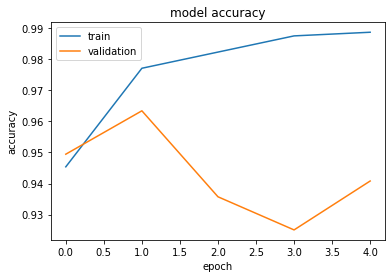

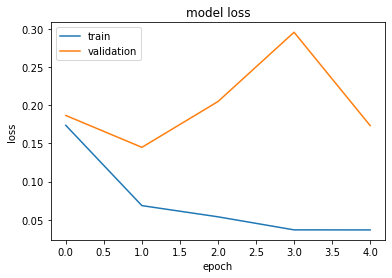

In [7]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [2]:
path_t = 'C:\\Users\\User\\MUSA\\Test'

datagen_t = ImageDataGenerator(rescale=1./255)

test_flow = datagen_t.flow_from_directory(path_t, 
                                         target_size=(254,254), 
                                         color_mode='rgb', 
                                         class_mode='binary',
                                         shuffle=False,
                                         batch_size=32)

Found 8617 images belonging to 2 classes.


In [3]:
from tensorflow.keras.models import load_model
cnn_saved = load_model('cnn_2cp.h5')

In [5]:
import math
predictions = cnn_saved.predict_generator(
    test_flow,
    verbose=1,
    steps=math.ceil(test_flow.samples/test_flow.batch_size)) 

270/270 [==============================] - 349s 1s/step


In [6]:
true_classes = test_flow.classes
predicted_classes = ((predictions > 0.5)*1)

In [8]:
from sklearn.metrics import classification_report
report = classification_report(
    true_classes,
    predicted_classes.reshape(8617, 1))
print(report)

              precision    recall  f1-score   support

           0       0.63      0.82      0.72      5137
           1       0.54      0.30      0.38      3480

    accuracy                           0.61      8617
   macro avg       0.59      0.56      0.55      8617
weighted avg       0.59      0.61      0.58      8617



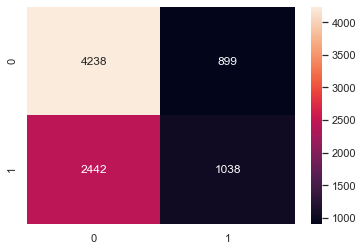

In [9]:
sns.set()
mat = confusion_matrix(true_classes, predicted_classes)
ax = sns.heatmap(mat, annot=True, fmt="d")

In [14]:
auc_score = sklearn.metrics.auc(recall, precision)
print('PR AUC =', auc_score)

PR AUC = 0.4805924576164972


### Attempting to Tackle Overfitting
#### Test Data is now being treated as validation Data

In [5]:
#adding in more data augmentation

path = 'C:\\Users\\User\\MUSA\\Training\\Training'
datagen = ImageDataGenerator(rescale=1./255,
                            horizontal_flip=True,
                             rotation_range = 30,
                             zoom_range=0.3)

train_gen = datagen.flow_from_directory(path, 
                                        target_size=(254,254),
                                        color_mode='rgb',
                                        class_mode='binary',
                                        batch_size=32)

path_t = 'C:\\Users\\User\\MUSA\\Test'

datagen_t = ImageDataGenerator(rescale=1./255)

test_flow = datagen_t.flow_from_directory(path_t, 
                                         target_size=(254,254), 
                                         color_mode='rgb', 
                                         class_mode='binary',
                                         batch_size=32)


Found 39375 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.


In [170]:
#adding batch normalization to each layer

img_input = (254,254,3)
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), padding="same", input_shape=img_input))
cnn.add(BatchNormalization())
cnn.add(LeakyReLU())
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(64, (3, 3), padding="same"))
cnn.add(BatchNormalization())
cnn.add(LeakyReLU())
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(64, (3, 3), padding="same"))
cnn.add(BatchNormalization())
cnn.add(LeakyReLU())
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Flatten())
cnn.add(Dense(64))
cnn.add(BatchNormalization())
cnn.add(LeakyReLU())
cnn.add(Dropout(0.7))
cnn.add(Dense(1))
cnn.add(Activation('sigmoid'))

cnn.compile(loss='binary_crossentropy',
              optimizer=Adam(lr = 0.001),
              metrics=['accuracy'])

In [ ]:
%%time
check = ModelCheckpoint(filepath='cnn_4cp.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

history = cnn.fit(train_gen,
                    steps_per_epoch= 39375 // 32,
                    epochs=40,
                    validation_data = test_flow, 
                    validation_steps = 8617 // 32,
                    callbacks=[early, check],
                    verbose=1)

Epoch 1/40
1230/1230 [==============================] - 6380s 5s/step - loss: 0.1338 - accuracy: 0.9548 - val_loss: 2.7792 - val_accuracy: 0.4282

Epoch 00001: val_loss improved from inf to 2.77919, saving model to cnn_4cp.h5
Epoch 2/40
1230/1230 [==============================] - 6378s 5s/step - loss: 0.0886 - accuracy: 0.9682 - val_loss: 2.3122 - val_accuracy: 0.5359

Epoch 00002: val_loss improved from 2.77919 to 2.31220, saving model to cnn_4cp.h5
Epoch 3/40
1230/1230 [==============================] - 6405s 5s/step - loss: 0.0689 - accuracy: 0.9748 - val_loss: 1.3076 - val_accuracy: 0.6679

Epoch 00003: val_loss improved from 2.31220 to 1.30757, saving model to cnn_4cp.h5
Epoch 4/40
1230/1230 [==============================] - 6373s 5s/step - loss: 0.0551 - accuracy: 0.9801 - val_loss: 2.6213 - val_accuracy: 0.5627

Epoch 00004: val_loss did not improve from 1.30757
Epoch 5/40
1230/1230 [==============================] - 6344s 5s/step - loss: 0.0510 - accuracy: 0.9819 - val_loss: 

In [6]:
#removing one of the convolutional layers

img_input = (254,254,3)
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), padding="same", input_shape=img_input))
cnn.add(BatchNormalization())
cnn.add(LeakyReLU())
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(64, (3, 3), padding="same"))
cnn.add(BatchNormalization())
cnn.add(LeakyReLU())
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Flatten())
cnn.add(Dense(64))
cnn.add(BatchNormalization())
cnn.add(LeakyReLU())
cnn.add(Dropout(0.5))
cnn.add(Dense(1))
cnn.add(Activation('sigmoid'))

cnn.compile(loss='binary_crossentropy',
              optimizer=Adam(lr = 0.001),
              metrics=['accuracy'])

In [ ]:
%%time
check = ModelCheckpoint(filepath='cnn_4cp.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

history = cnn.fit(train_gen,
                    steps_per_epoch= 39375 // 32,
                    epochs=40,
                    validation_data = test_flow, 
                    validation_steps = 8617 // 32,
                    callbacks=[early, check],
                    verbose=1)

Epoch 1/40
1230/1230 [==============================] - 9387s 8s/step - loss: 0.1439 - accuracy: 0.9508 - val_loss: 3.5171 - val_accuracy: 0.3994

Epoch 00001: val_loss improved from inf to 3.51711, saving model to cnn_4cp.h5
Epoch 2/40
1230/1230 [==============================] - 6272s 5s/step - loss: 0.1021 - accuracy: 0.9651 - val_loss: 1.6647 - val_accuracy: 0.6132

Epoch 00002: val_loss improved from 3.51711 to 1.66465, saving model to cnn_4cp.h5
Epoch 3/40
1230/1230 [==============================] - 6315s 5s/step - loss: 0.0835 - accuracy: 0.9701 - val_loss: 2.0692 - val_accuracy: 0.5536

Epoch 00003: val_loss did not improve from 1.66465
Epoch 4/40
1230/1230 [==============================] - 6508s 5s/step - loss: 0.0726 - accuracy: 0.9736 - val_loss: 3.0340 - val_accuracy: 0.5270

Epoch 00004: val_loss did not improve from 1.66465
Epoch 5/40
 144/1230 [==>...........................] - ETA: 1:51:18 - loss: 0.0696 - accuracy: 0.9744

### Looking at Color Distributions on Training vs Testing Set

In [166]:
def get_colors(df):
    colors = []
    for d in df['path']:
        img = cv2.imread(d)
        avg_color_per_row = np.average(img, axis=0)
        avg_color = np.average(avg_color_per_row, axis=0)
        colors.append(avg_color)
    return np.array(colors)

In [ ]:
a = get_colors(image_df_train_f)
b = get_colors(image_df_train_nf)

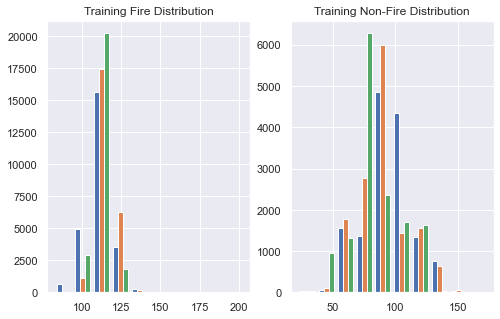

In [168]:
plt.figure(figsize=(8,5))
plt.subplot(1, 2, 1)
plt.hist(a)
plt.title("Training Fire Distribution")

plt.subplot(1, 2, 2)
plt.hist(b)
plt.title("Training Non-Fire Distribution")
plt.show()

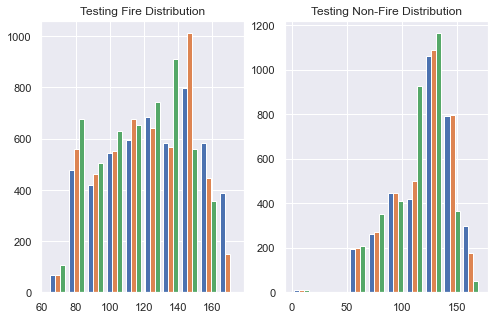

In [169]:
a = get_colors(image_df_test_f)
b = get_colors(image_df_test_nf)
plt.figure(figsize=(8,5))
plt.subplot(1, 2, 1)
plt.hist(a)
plt.title("Testing Fire Distribution")

plt.subplot(1, 2, 2)
plt.hist(b)
plt.title("Testing Non-Fire Distribution")
plt.show()

### Training CNN with custom split from combined training and testing data
#### Using Test data as validation data

In [2]:
path = 'C:\\Users\\User\\MUSA\\New_Train'
datagen = ImageDataGenerator(rescale=1./255,
                             validation_split=0.25)

train_gen = datagen.flow_from_directory(path, 
                                        target_size=(254,254),
                                        color_mode='rgb',
                                        class_mode='binary',
                                        batch_size=32,
                                        shuffle=True,
                                        subset='training')

test_flow = datagen.flow_from_directory(path, 
                                      target_size=(254,254), 
                                      color_mode='rgb',
                                      class_mode='binary',
                                      batch_size=32,
                                      shuffle=True,
                                      subset='validation')

Found 35995 images belonging to 2 classes.
Found 11997 images belonging to 2 classes.


In [3]:
img_input = (254,254,3)
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), padding="same", input_shape=img_input))
cnn.add(BatchNormalization())
cnn.add(LeakyReLU())
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(64, (3, 3), padding="same"))
cnn.add(BatchNormalization())
cnn.add(LeakyReLU())
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Flatten())
cnn.add(Dense(64))
cnn.add(BatchNormalization())
cnn.add(LeakyReLU())
cnn.add(Dropout(0.5))
cnn.add(Dense(1))
cnn.add(Activation('sigmoid'))

cnn.compile(loss='binary_crossentropy',
              optimizer=Adam(lr = 0.001),
              metrics=['accuracy'])

In [4]:
%%time
check = ModelCheckpoint(filepath='new_cnn_cp.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', patience=4, verbose=1)

history = cnn.fit(train_gen,
                    steps_per_epoch= 35995 // 32,
                    epochs=40,
                    validation_data = test_flow, 
                    validation_steps = 11997 // 32,
                    callbacks=[early, check],
                    verbose=1)

Epoch 1/40
1124/1124 [==============================] - 5783s 5s/step - loss: 0.1855 - accuracy: 0.9291 - val_loss: 1.7096 - val_accuracy: 0.5536

Epoch 00001: val_loss improved from inf to 1.70956, saving model to new_cnn_cp.h5
Epoch 2/40
1124/1124 [==============================] - 5121s 5s/step - loss: 0.0343 - accuracy: 0.9895 - val_loss: 0.6520 - val_accuracy: 0.8235

Epoch 00002: val_loss improved from 1.70956 to 0.65199, saving model to new_cnn_cp.h5
Epoch 3/40
1124/1124 [==============================] - 5043s 4s/step - loss: 0.0196 - accuracy: 0.9939 - val_loss: 0.5013 - val_accuracy: 0.9208

Epoch 00003: val_loss improved from 0.65199 to 0.50131, saving model to new_cnn_cp.h5
Epoch 4/40
1124/1124 [==============================] - 5072s 5s/step - loss: 0.0164 - accuracy: 0.9946 - val_loss: 4.1445 - val_accuracy: 0.4775

Epoch 00004: val_loss did not improve from 0.50131
Epoch 5/40
1124/1124 [==============================] - 4884s 4s/step - loss: 0.0180 - accuracy: 0.9941 - v

### Training CNN with Custom Split (Test Data has been put aside)

In [14]:
path = 'C:\\Users\\User\\MUSA\\New_Train'
datagen = ImageDataGenerator(rescale=1./255,
                             validation_split=0.2)

train_gen = datagen.flow_from_directory(path, 
                                        target_size=(254,254),
                                        color_mode='rgb',
                                        class_mode='binary',
                                        batch_size=32,
                                        shuffle=True,
                                        subset='training')

val_gen = datagen.flow_from_directory(path, 
                                      target_size=(254,254), 
                                      color_mode='rgb',
                                      class_mode='binary',
                                      batch_size=32,
                                      shuffle=True,
                                      subset='validation')

Found 28789 images belonging to 2 classes.
Found 7196 images belonging to 2 classes.


In [7]:
path_t = 'C:\\Users\\User\\MUSA\\Testing_Mixed'

datagen_t = ImageDataGenerator(rescale=1./255)

test_flow = datagen_t.flow_from_directory(path_t, 
                                         target_size=(254,254), 
                                         color_mode='rgb', 
                                         class_mode='binary',
                                          shuffle=False,
                                         batch_size=32)


Found 11998 images belonging to 2 classes.


In [3]:
img_input = (254,254,3)
cnn = Sequential(name='Final_CNN')
cnn.add(Conv2D(32, (3, 3), padding="same", input_shape=img_input))
cnn.add(BatchNormalization())
cnn.add(LeakyReLU())
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(64, (3, 3), padding="same"))
cnn.add(BatchNormalization())
cnn.add(LeakyReLU())
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Flatten())
cnn.add(Dense(64))
cnn.add(BatchNormalization())
cnn.add(LeakyReLU())
cnn.add(Dropout(0.5))
cnn.add(Dense(1))
cnn.add(Activation('sigmoid'))

cnn.compile(loss='binary_crossentropy',
              optimizer=Adam(lr = 0.001),
              metrics=['accuracy'])

In [6]:
cnn.summary()

Model: "Final_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 254, 254, 32)      128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 127, 127, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 127, 127, 64)      0 

In [4]:
%%time
check = ModelCheckpoint(filepath='finall_cnn.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

history = cnn.fit(train_gen,
                    steps_per_epoch= 28787 // 32,
                    epochs=26,
                    validation_data = val_gen, 
                    validation_steps = 7195 // 32,
                    callbacks=[early, check],
                    verbose=1)

Epoch 1/26
899/899 [==============================] - 3804s 4s/step - loss: 0.2099 - accuracy: 0.9238 - val_loss: 0.1163 - val_accuracy: 0.9609

Epoch 00001: val_loss improved from inf to 0.11626, saving model to finall_cnn.h5
Epoch 2/26
899/899 [==============================] - 3738s 4s/step - loss: 0.0518 - accuracy: 0.9831 - val_loss: 0.3412 - val_accuracy: 0.8449

Epoch 00002: val_loss did not improve from 0.11626
Epoch 3/26
899/899 [==============================] - 3729s 4s/step - loss: 0.0266 - accuracy: 0.9917 - val_loss: 0.7244 - val_accuracy: 0.6910

Epoch 00003: val_loss did not improve from 0.11626
Epoch 4/26
899/899 [==============================] - 3734s 4s/step - loss: 0.0198 - accuracy: 0.9937 - val_loss: 0.2062 - val_accuracy: 0.9442

Epoch 00004: val_loss did not improve from 0.11626
Epoch 00004: early stopping
Wall time: 4h 10min 6s


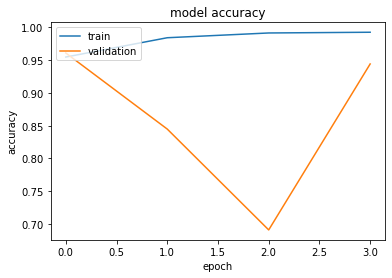

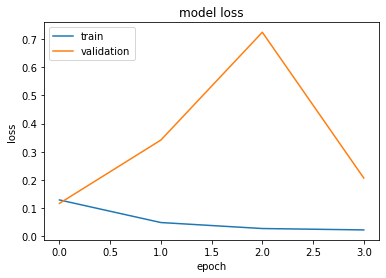

In [5]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [6]:
from tensorflow.keras.models import load_model
cnn_saved = load_model('finall_cnn.h5')

In [8]:
predictions = cnn_saved.predict_generator(
    test_flow,
    verbose=1,
    steps=math.ceil(test_flow.samples/test_flow.batch_size)) 

375/375 [==============================] - 438s 1s/step


In [9]:
true_classes = test_flow.classes
predicted_classes = ((predictions > 0.5)*1)

In [10]:
from sklearn.metrics import classification_report
report = classification_report(
    true_classes,
    predicted_classes)
print(report)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      7536
           1       0.99      0.91      0.95      4462

    accuracy                           0.96     11998
   macro avg       0.97      0.95      0.96     11998
weighted avg       0.96      0.96      0.96     11998



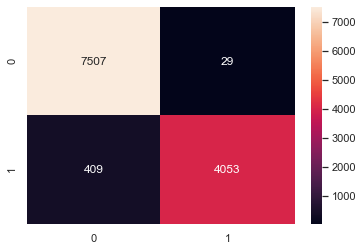

In [11]:
sns.set()
mat = confusion_matrix(true_classes, predicted_classes)
ax = sns.heatmap(mat, annot=True, fmt="d")

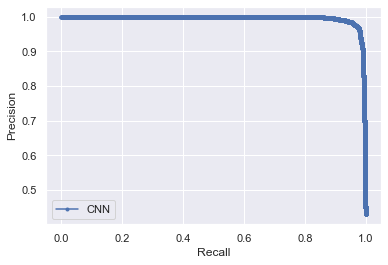

In [12]:
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(true_classes, predictions)
# plot the model precision-recall curve
pyplot.plot(recall, precision, marker='.', label='CNN')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [13]:
auc_score = sklearn.metrics.auc(recall, precision)
print('PR AUC =', auc_score)

PR AUC = 0.9950803540198254
